# Randomized Autoencoder Ensembles for Unsupervised Outlier Detection

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, cohen_kappa_score

from tqdm import tqdm

Our plan is to look into using autoencoders for outlier detection and in particular, test randomized autoencoder ensembles against some standard methods (Elliptic Envelopes, LOF and Isolation Forests). The autoencoder model will be based on [Jinghui Chen, Saket Sathe, Charu Aggarwal, Deepak Turaga. Outlier Detection with Autoencoder Ensembles. SIAM SDM, 2017](https://saketsathe.net/downloads/autoencode.pdf):

- we will fit autoencoders and measure the degree of outlier-ness by the reconstruction loss;
- the autoencoders are fit on random samples of the data and connections in the neural nets are dropped randomly to increase diversity;
- we train the models using adaptive sampling, using more and more data as the training progresses;
- we score each data point by the median reconstruction loss of our ensemble.


More resources:

- [Outlier book by C. Aggarval](http://charuaggarwal.net/outlierbook.pdf)
- [Outlier eval by Schubert et at](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2012/SDM12-outlierevaluation.pdf)
- [General resource collection](https://github.com/yzhao062/anomaly-detection-resources)

## Data - dummy 

In [323]:
n_samples = 10000
contamination = 0.01
n_outliers = int(n_samples*contamination)
outlier_range = 10
n_features = 2

data = np.random.randn(n_samples, n_features)
data[:n_outliers, :] = np.random.uniform(-1*outlier_range, outlier_range, size=(n_outliers, n_features))
data = pd.DataFrame(data, columns = [f"feature_{i}" for i in range(n_features)])
data["outlier"] = np.concatenate([np.ones((n_outliers,)), np.zeros((n_samples-n_outliers,))], axis=0)

In [322]:
plt.figure()
sns.scatterplot(x="feature_0", y="feature_1", hue="outlier", data=data)
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 432x288 with 1 Axes>

In [275]:
X = data.drop("outlier", axis=1)
y = data.outlier

y.mean()

0.03

## Data - Wordline 

We will work with credit card data from [Wordline & ULB](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [226]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [227]:
data.shape

(284807, 31)

The proportion of outliers is around 0.17%:

In [236]:
data["Class"].mean()

0.001727485630620034

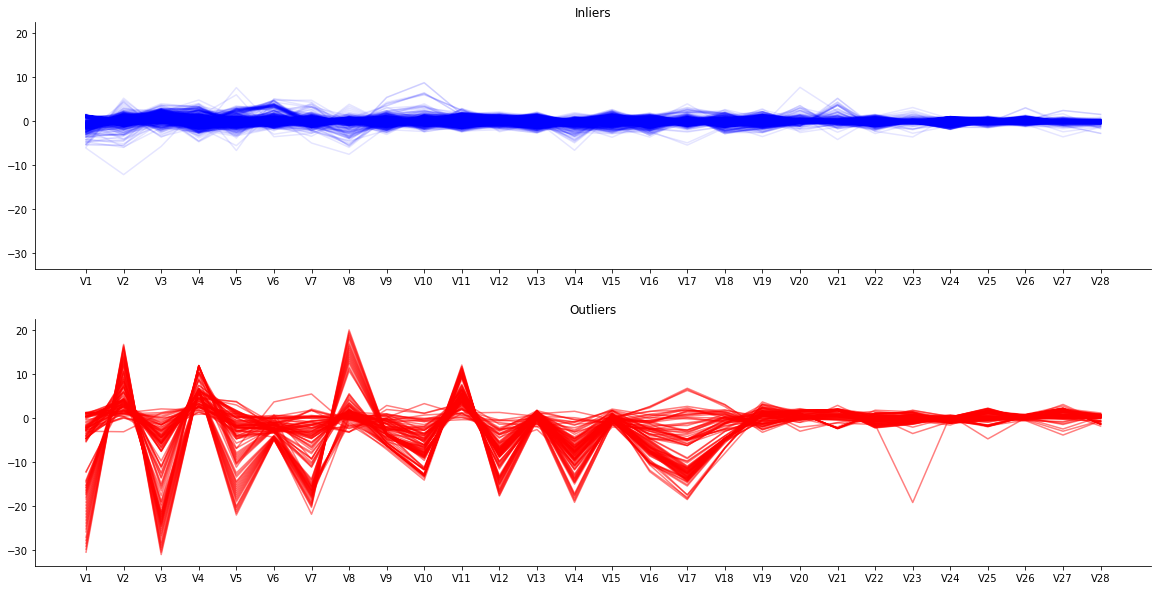

In [237]:
inlier_data = data[data.Class == 0].reset_index()
outlier_data = data[data.Class == 1].reset_index()

feature_cols = [col for col in data.columns if col.startswith("V")]

fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=True)
axs[0].plot(inlier_data.loc[:1000, feature_cols].T, c="blue", alpha=0.1)
axs[0].set_title("Inliers")
axs[1].plot(outlier_data.loc[:100, feature_cols].T, c="red", alpha=0.5)
axs[1].set_title("Outliers")
sns.despine()
plt.show()

The outliers are definitely showing different behaviour, much higher variance in many features. There also seems to some clustering among the inliers (around V5/6 there seems to be a distict group).

In [232]:
plot_data = data.drop("Time", axis=1).melt(value_vars=feature_cols, 
                    id_vars=["Class"], 
                    var_name='groups', 
                    value_name='vals')

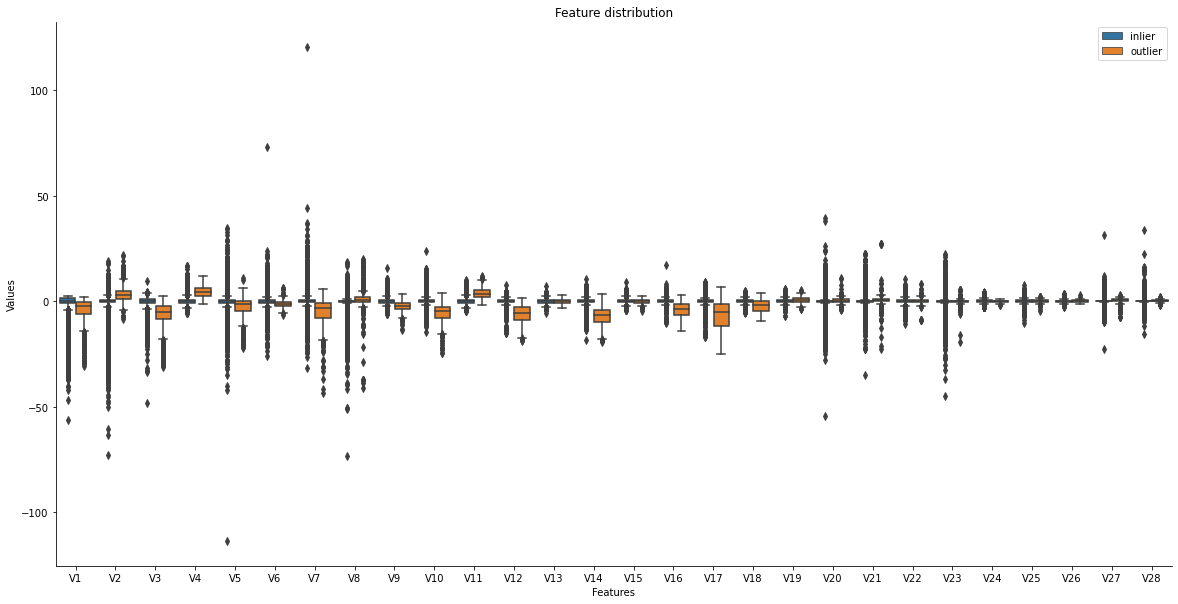

In [238]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="groups", y="vals", hue="Class", data=plot_data, ax=axs)
sns.despine()
plt.xlabel("Features")
plt.ylabel("Values")
L=plt.legend()
L.get_texts()[0].set_text('inlier')
L.get_texts()[1].set_text('outlier')
plt.title("Feature distribution")
plt.show()

The data is centered and the variance is pretty much on the same scale. However, to train autoencoders we will need to do some scaling.

In [235]:
feature_stats = data[feature_cols].apply([np.std, np.mean]).T
feature_stats

,std,mean
V1,1.958696,1.165980e-15
V2,1.651309,3.416908e-16
V3,1.516255,-1.373150e-15
V4,1.415869,2.086869e-15
V5,1.380247,9.604066e-16
V6,1.332271,1.490107e-15
V7,1.237094,-5.556467e-16
V8,1.194353,1.177556e-16
V9,1.098632,-2.406455e-15
V10,1.088850,2.239751e-15


## t-SNE visualization 

Before the modeling, we can visualize some of our data. We will pick 5000 inliers and all the outliers and see if there are some patterns.

In [248]:
inlier_sample = data.loc[data.Class == 0, feature_cols].sample(5000).values
outliers = data.loc[data.Class == 1, feature_cols].values

vis_data = np.concatenate([inlier_sample, outliers], axis=0)
vis_labels = np.concatenate([np.zeros((inlier_sample.shape[0],)), np.ones((outliers.shape[0],))])
vis_data.shape, vis_labels.shape

((5492, 28), (5492,))

In [249]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(vis_data)

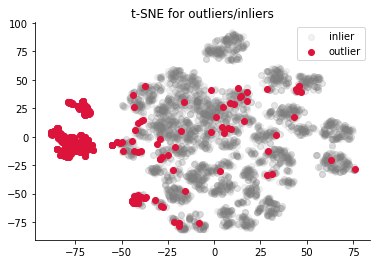

In [251]:
plt.figure()
plt.scatter(tsne_data[vis_labels == 0, 0], 
            tsne_data[vis_labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[vis_labels == 1, 0], 
            tsne_data[vis_labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers")
plt.savefig("tsne_wordline.png")
plt.show()

There is definitely strong separation among some of the outliers. But keeping in mind that we would like to do **unsupervised** outlier detection, it is not clear how we would tell apart the outlier clusters from some of the inlier blobs.

## Outlier detection baselines

We will use some [outlier detection baselines from sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py).

In [296]:
X = data[feature_cols].values
y = data["Class"].values

### Elliptic Envelopes

Our second baseline is a paramteric method: by assuming that inlier data points are from a Gaussian distribution, we can measure the degree of outlier-ness by the fitted distribution. We perform a robust mean and covariance estimation (which should not be affected by outliers) and calculate the Mahalanobis distances to derive a measure of outlyingness. 

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope).

In [ ]:
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, make_scorer


model = EllipticEnvelope(contamination=y.mean(), support_fraction=0.95)

scoring = {"precision": precision_score, 
           "recall": recall_score, 
           "cohen": cohen_kappa_score} 

results = pd.DataFrame(columns=scoring.keys())

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}...", end="\r")
    model.fit(X[train_index])
    y_pred = model.predict(X[test_index])
    y_pred = np.where(y_pred == 1, 0, 1) 
    
    for name_, score in scoring.items():
        results.loc[i, name_] = score(y[test_index], y_pred) 

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Elliptic Envelope evaluation")
plt.show()

### Isolation Forest 

Lastly, another non-parametric method is the Isolation Forest. The idea is that a decision tree can isolate outlier data points (by splitting the data along features) by much shorter branches than inliers. We randomly select features and split values, recursively partitioning our data. The path length, averaged over a forest of such random trees, is a measure of inlier-ness: the longer the path the more regular the data point is.

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

In [299]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=50, contamination=y.mean(),)

scoring = {"precision": precision_score, 
           "recall": recall_score, 
           "cohen": cohen_kappa_score} 

results = pd.DataFrame(columns=scoring.keys())

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}...", end="\r")
    model.fit(X[train_index])
    y_pred = model.predict(X[test_index])
    y_pred = np.where(y_pred == 1, 0, 1) 
    
    for name_, score in scoring.items():
        results.loc[i, name_] = score(y[test_index], y_pred) 

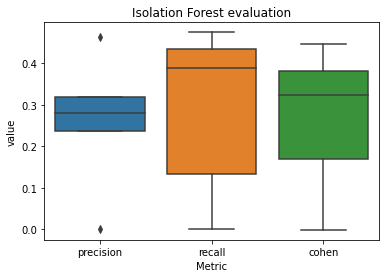

In [300]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("Isolation Forest evaluation")
plt.show()

### Local Outlier Factors 

This is a non-parametric, density-based method that finds outliers by looking for data points which have significantly lower local densities than their neighbouring points. The rough algorithm is as follows:

1. Find the k-nearest neighbors and use the distance to estimate a local density;
2. Compare local densities with neighbours to detect outliers.

LOF being a distance-based method, it's important that our data is scaled. See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=5, contamination=y_train.mean(), n_jobs=-1) # n_neighbours should be tuned

scoring = {"precision": precision_score, 
           "recall": recall_score, 
           "cohen": cohen_kappa_score} 

results = pd.DataFrame(columns=scoring.keys())

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}...", end="\r")
    model.fit(X[train_index])
    y_pred = model.predict(X[test_index])
    y_pred = np.where(y_pred == 1, 0, 1) 
    
    for name_, score in scoring.items():
        results.loc[i, name_] = score(y[test_index], y_pred) 

In [ ]:
plt.figure()
sns.boxplot(x="variable", y="value", data=results.melt())
plt.xlabel("Metric")
plt.title("LOF evaluation")
plt.show()

## Randomized autoencoders

We will build an autoencoder class that can mask connections in its layers.

In [252]:
class RandAE(tf.keras.Sequential):
    def __init__(self, input_dim, hidden_dims, drop_ratio=0.5, **kwargs):
        super(RandAE, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.drop_ratio = drop_ratio
        
        self.layer_masks = dict()
        
        self.build_model()
                
    def build_model(self) -> None:
        """
        Adds the layers and records masks.
        """
        
        self.add(layers.Input(self.input_dim, name="input"))
        
        for i, dim in enumerate(self.hidden_dims):
            layer_name = f"hidden_{i}"
            layer = layers.Dense(dim, 
                                 activation="relu" if i > 0 else "sigmoid", 
                                 name=layer_name)
            self.add(layer)
            
            # add layer mask
            self.layer_masks[layer_name] = self.get_mask(layer)
        
        layer_name = "output"
        output_layer = layers.Dense(self.input_dim, activation="sigmoid", name=layer_name)
        self.add(output_layer)
        self.layer_masks[layer_name] = self.get_mask(output_layer)
            
    def get_mask(self, layer) -> np.ndarray:
        """
        Build mask for a layer.
        """
        
        shape = layer.input_shape[1], layer.output_shape[1]
        
        return np.random.choice([0., 1.], size=shape, p=[self.drop_ratio, 1-self.drop_ratio])
        
            
    def get_encoder(self) -> keras.Sequential:
        """
        Get the encoder from the full model.
        """
        
        n_layers = (len(self.hidden_dims)+1)//2
        encoder_layers = [layers.Input(self.input_dim)] + self.layers[:n_layers]

        return keras.Sequential(encoder_layers)
        
    
    def mask_weights(self) -> None:
        """
        Apply the masks to each layer in the encoder and decoder.
        """
        
        for layer in self.layers:
            layer_name = layer.name
            if layer_name in self.layer_masks:
                masked_w = layer.weights[0].numpy()*self.layer_masks[layer_name]
                b = layer.weights[1].numpy()
                layer.set_weights((masked_w, b))        

    def call(self, data, training=True) -> tf.Tensor:
        
        # mask the weights before original forward pass
        self.mask_weights()
        
        return super().call(data)

We can preform some sanity checks on our model:

In [200]:
# test compile
model = RandAE(32, [16, 8, 4, 8, 16])
model.compile(optimizer="adam", loss="mse", run_eagerly=True)

In [201]:
# structure
model.summary()

Model: "rand_ae_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_0 (Dense)             (None, 16)                528       
_________________________________________________________________
hidden_1 (Dense)             (None, 8)                 136       
_________________________________________________________________
hidden_2 (Dense)             (None, 4)                 36        
_________________________________________________________________
hidden_3 (Dense)             (None, 8)                 40        
_________________________________________________________________
hidden_4 (Dense)             (None, 16)                144       
_________________________________________________________________
output (Dense)               (None, 32)                544       
Total params: 1,428
Trainable params: 1,428
Non-trainable params: 0
______________________________________________________

In [202]:
# check weights before first call
for layer in model.layers:
    pct = np.round((layer.weights[0].numpy() == 0).mean()*100, 2)
    print(f"{layer.name} has {pct}% exact-0 weights.")

hidden_0 has 0.0% exact-0 weights.
hidden_1 has 0.0% exact-0 weights.
hidden_2 has 0.0% exact-0 weights.
hidden_3 has 0.0% exact-0 weights.
hidden_4 has 0.0% exact-0 weights.
output has 0.0% exact-0 weights.


In [203]:
# test forward with sample data
data = np.random.randn(128, 32)
output = model(data)

In [204]:
# print 0 weight ratios again
for layer in model.layers:
    pct = np.round((layer.weights[0].numpy() == 0).mean()*100, 2)
    print(f"{layer.name} has {pct}% exact-0 weights.")

hidden_0 has 50.0% exact-0 weights.
hidden_1 has 41.41% exact-0 weights.
hidden_2 has 53.12% exact-0 weights.
hidden_3 has 46.88% exact-0 weights.
hidden_4 has 46.88% exact-0 weights.
output has 45.31% exact-0 weights.


The weights look good!

## Outliers on the latent manifold

We can do a quick EDA-type test run and see if our model can learn a better latent represenation of the data. Note that 
- our sigmoid activation in the last layer require the data to be scaled between 0 and 1;
- we set `drop_ratio=0` so we have a regular autoencoder.

In [260]:
scaler = MinMaxScaler() 
X = scaler.fit_transform(data[feature_cols].values)

model = RandAE(X.shape[1], [16], drop_ratio=0)
model.compile(optimizer="adam", loss="mse", run_eagerly=True)

history = model.fit(X, X, epochs=5, batch_size=128)

Epoch 1/5
2226/2226 [==============================] - 49s 22ms/step - loss: 0.0029
Epoch 2/5
2226/2226 [==============================] - 49s 22ms/step - loss: 0.0014
Epoch 3/5
2226/2226 [==============================] - 49s 22ms/step - loss: 7.2634e-04
Epoch 4/5
2226/2226 [==============================] - 49s 22ms/step - loss: 3.8355e-04
Epoch 5/5
2226/2226 [==============================] - 49s 22ms/step - loss: 2.9053e-04


The baseline MSE was around 0.0017 so there was definitely a fair amount of learning.

In [266]:
np.square(X-X.mean(axis=0)).mean()

0.0017584607851097484

Now we can use the encoder to get the latent representation of the plot data:

In [261]:
encoder = model.get_encoder()

vis_data_latent = encoder.predict(scaler.transform(vis_data))

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(vis_data_latent)

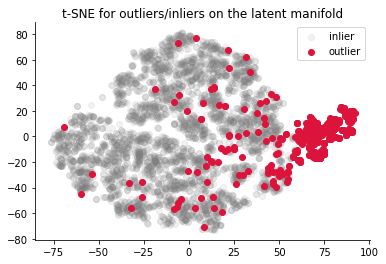

In [262]:
plt.figure()
plt.scatter(tsne_data[vis_labels == 0, 0], 
            tsne_data[vis_labels == 0, 1], c="grey", alpha=0.1, label="inlier")
plt.scatter(tsne_data[vis_labels == 1, 0], 
            tsne_data[vis_labels == 1, 1], c="crimson", alpha=1, label="outlier")
plt.legend()
sns.despine()
plt.title("t-SNE for outliers/inliers on the latent manifold")
plt.savefig("tsne_wordline_latent_2.png")
plt.show()

The image changed somewhat. There is still a fair mixing of the inliers and outliers, but I would say that the inliers are more clustered together with no blobs separating. The outlier group is still quite distinct which is a good sign.

## Detecting outliers based on reconstruction loss

We can look for the outliers using our autoencoder by selecting the points with the largest reconstruction loss.

In [268]:
input_data = X
input_labels = data.Class.values

# make ensemble predictions
pred = model.predict(X)

In [269]:
reconstruction_loss = np.square(pred - input_data).mean(axis=1)

In [271]:
# set threshold by the population contamination
threshold = np.quantile(reconstruction_loss, 1-input_labels.mean())
outlier_pred = np.where(reconstruction_loss > threshold, 1, 0)

In [272]:
cr = classification_report(input_labels, outlier_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.45      0.45      0.45       492

    accuracy                           1.00    284807
   macro avg       0.72      0.72      0.72    284807
weighted avg       1.00      1.00      1.00    284807



A more wholesome picture comes from looking at the full Precision-Recall curve.

In [275]:

min_ = reconstruction_loss.min()
max_ = reconstruction_loss.max()
scaled_loss = (reconstruction_loss - min_)/(max_ - min_)

prec, recall, thresholds = precision_recall_curve(input_labels, scaled_loss)

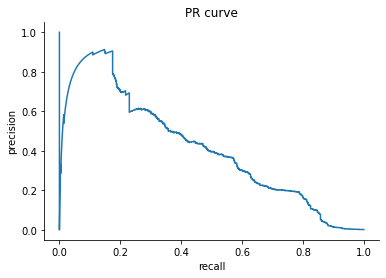

In [279]:
plt.figure()
plt.plot(recall, prec)
plt.xlabel("recall")
plt.ylabel("precision")
sns.despine()
plt.title("PR curve")
plt.show()

Finally, we can look at Cohen's kappa. This is a measure of agreement between two arrays that takes into account by-chance equality. The values range between 1 and -1 with the former being the best score.

In [281]:
cohen_kappa_score(input_labels, outlier_pred)

0.44619778617813266

## Data loaders for adaptive learning

We want to change our training data as we progress during training and feed more and more samples to the model in later epochs. For this, we will write a custom data loader.

In [224]:
from tensorflow import keras
import warnings, math

class AdaptiveDataGenerator(keras.utils.Sequence):
    def __init__(self, x, batch_size, alpha=1.01, subsample=0.3, shuffle=True, verbose=False):
        self.x = x
        self.subsample = subsample
        self.verbose = verbose
        
        if self.subsample:
            sample_idx = np.random.choice(self.x.shape[0], size=int(self.subsample*self.x.shape[0]))
            self.x = self.x[sample_idx]
            
        self.batch_size = batch_size
        
        # adaptive learning params
        self.alpha = alpha
        if self.alpha <= 1:
            raise warnings.warn("Alpha should be set to > 1 to increase training data.")
        self.shuffle = shuffle
        
        # per epoch variables
        self.epoch = 0
        self.train_ratio = 0.5
        self.current_x = None
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.current_x) / self.batch_size)
    
    def __getitem__(self, idx):
        """
        Return a batch for autoencoder training.
        """
        
        batch = self.current_x[idx*self.batch_size: (idx+1)*self.batch_size]
        
        return batch, batch
    
    def on_epoch_end(self):
        """
        Called before training and after every epoch to include more and more training data.
        """
        
        # slice training data for the next epoch
        slice_idx = int(self.train_ratio*self.x.shape[0])
        self.current_x = self.x[:slice_idx]
        
        # shuffle rows to mix data in different batches
        if self.shuffle:
            rand_idx = np.arange(self.current_x.shape[0])
            np.random.shuffle(rand_idx)
            self.current_x = self.current_x[rand_idx]
            
        if self.verbose:
            print(f"Epoch {self.epoch} -- {self.current_x.shape[0]/self.x.shape[0]*100}% data")
        
        # update training params
        self.train_ratio = min(self.train_ratio*self.alpha, 1)
        self.epoch += 1

Some sanity checks:

In [225]:
import unittest

class TestAdaptiveDataGenerator(unittest.TestCase):
    def setUp(self):
        self.data = np.random.randn(1000, 10)
        self.batch_size = 32
        self.generator = AdaptiveDataGenerator(self.data, self.batch_size, verbose=True)
        self.model = RandAE(input_dim=10, hidden_dims=[16, 8, 16])
        self.model.compile(optimizer="adam", loss="mse", run_eagerly=True)
    
    def test_init(self):
        self.assertEqual(self.generator.current_x.shape[0], 1000*0.3*0.5)
    
    def test_fit(self):
        self.model.fit_generator(generator=self.generator,
                                 epochs=10)
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_fit (__main__.TestAdaptiveDataGenerator) ... 

Epoch 0 -- 50.0% data
Epoch 1/10
5/5 [==============================] - 0s 17ms/step - loss: 1.2313
Epoch 1 -- 50.33333333333333% data
Epoch 2/10
5/5 [==============================] - 0s 15ms/step - loss: 1.2342
Epoch 2 -- 51.0% data
Epoch 3/10
5/5 [==============================] - 0s 21ms/step - loss: 1.2321
Epoch 3 -- 51.33333333333333% data
Epoch 4/10
5/5 [==============================] - 0s 19ms/step - loss: 1.2355
Epoch 4 -- 52.0% data
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 1.2398
Epoch 5 -- 52.33333333333333% data
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 1.2383
Epoch 6 -- 53.0% data
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 1.2333
Epoch 7 -- 53.333333333333336% data
Epoch 8/10
5/5 [==============================] - 0s 18ms/step - loss: 1.2366
Epoch 8 -- 54.0% data
Epoch 9/10
5/5 [==============================] - 0s 20ms/step - loss: 1.2244
Epoch 9 -- 54.666666666666664% data
Epoch 10/10

ok
test_init (__main__.TestAdaptiveDataGenerator) ... 

Epoch 10 -- 55.00000000000001% data
Epoch 0 -- 50.0% data


ok

----------------------------------------------------------------------
Ran 2 tests in 1.657s

OK


## Data scaling for training

We will do just very basic preprocessing:

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

scale = True
if scale:
    scaler_pipe = Pipeline([("robust", RobustScaler(quantile_range=(0.1, 0.9))),
                       ("minmax", MinMaxScaler(feature_range=(0, 1)))])

    X_train = scaler_pipe.fit_transform(X_train)
    X_test = scaler_pipe.transform(X_test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

In [368]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 29), (227845, 1), (56962, 29), (56962, 1))

In [369]:
y_train.sum(), y_test.sum()

(394, 98)

## Training the ensemble

In [395]:
MODEL_PARAMS ={"input_dim": X_train.shape[1],
               "hidden_dims": [16, 8],
               "drop_ratio": 0.1}

COMPILE_PARAMS = {"optimizer": keras.optimizers.Adam(learning_rate=1e-3),
                 "loss": keras.losses.MeanSquaredError(),
                 "run_eagerly": True,}

TRAIN_PARAMS = {"epochs": 10,
                "batch_size": 128,
                "verbose": 1}

n_models = 10
ensemble = []

from tqdm import tqdm
import pickle

for i in tqdm(range(n_models)):
    model = RandAE(**MODEL_PARAMS)
    model.compile(**COMPILE_PARAMS)

    model.fit(X_train, 
              X_train,
              **TRAIN_PARAMS
          )

    model.save_weights(f"models/randae_model_{i}")
    
    with open(f'model_{i}_masks.pickle', 'wb') as handle:
        pickle.dump(model.layer_masks, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    ensemble.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0065
Epoch 2/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0017
Epoch 3/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0017
Epoch 4/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0017
Epoch 5/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0016
Epoch 6/10
1781/1781 [==============================] - 12s 7ms/step - loss: 0.0014
Epoch 7/10
 594/1781 [=========>....................] - ETA: 8s - loss: 0.0014

  0%|          | 0/10 [01:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# load models
# TODO: need to save/load the masks!!
ensemble = [RandAE(**MODEL_PARAMS) for i in range(n_models)]
for model in ensemble:
    model.load_weights(f"models/randae_model_{i}")
    model.compile(run_eagerly=True)

In [ ]:
input_data = X_test
input_labels = y_test

# make ensemble predictions
predictions = [model.predict(input_data) for model in ensemble]

In [ ]:
reconstruction_loss = np.stack([np.square((pred - input_data)).mean(axis=1) for pred in predictions], axis=1)
median_loss = np.median(reconstruction_loss, axis=1)

threshold = np.quantile(median_loss, 1-y_train.mean())
test_outliers = np.where(median_loss > threshold, 1, 0)

In [ ]:
cr = classification_report(input_labels, test_outliers)
print(cr)